In [1]:
# Covid19 Analysis

# Data from Espírito Santo government
# http://plataforma.saude.gov.br/coronavirus/dados-abertos/        (18 may) 

In [2]:
# libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
import pickle
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from datetime import datetime
from xgboost import XGBClassifier


/home/pedro/anaconda3/lib/python3.7/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# reading dataset

df = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v4/dataset/INFLUD-16-06-2020-Revisado.csv',sep=';',encoding = "ISO-8859-1")

# Inputing constraint in the dataset 

# Positive case:

df = df[df['PCR_SARS2']==1]
print(df.shape)


# Hospitalized people:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1]
print(df.shape)

# Hospitalized people with age small than 110:

df = df[df['PCR_SARS2']==1][df['HOSPITAL']==1][df['NU_IDADE_N']<=110][df['EVOLUCAO'] != 9][df['EVOLUCAO'].notnull()]
print(df.shape)


/home/pedro/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,59,61,62,63,103,105,119,126,128,129,130,132) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(97924, 134)
(90133, 134)
(66929, 134)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [4]:
# IDHM

# Reading IBGE code for each municipalities and separating it for IDHM index

df_atlas = pd.read_excel (r'/home/pedro/Desktop/autoprognosis/code_v4/dataset/AtlasBrasil_Consulta.xlsx')


# removind last interger in 'code' variable

df_atlas['code'] = df_atlas['code'].astype(str).str[:-1].astype(np.int64)


# Divinding IDHM in bins

IDHM_veryhigh  =  set(df_atlas['code'][df_atlas['IDHM2010']>=0.800])
print(len(IDHM_veryhigh))


IDHM_high  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.700)&(df_atlas['IDHM2010']<0.800))])
print(len(IDHM_high))


IDHM_medium  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.600)&(df_atlas['IDHM2010']<0.700))])
print(len(IDHM_medium))


IDHM_low  =  set(df_atlas['code'][((df_atlas['IDHM2010']>=0.500)&(df_atlas['IDHM2010']<0.600))])
print(len(IDHM_low))


IDHM_verylow  =  set(df_atlas['code'][df_atlas['IDHM2010']<0.500])
print(len(IDHM_verylow))




df.loc[df['CO_MUN_NOT'].isin(IDHM_veryhigh) == True, 'IDHM'] = 5
df.loc[df['CO_MUN_NOT'].isin(IDHM_high) == True, 'IDHM'] = 4
df.loc[df['CO_MUN_NOT'].isin(IDHM_medium) == True, 'IDHM'] = 3
df.loc[df['CO_MUN_NOT'].isin(IDHM_low) == True, 'IDHM'] = 2
df.loc[df['CO_MUN_NOT'].isin(IDHM_verylow) == True, 'IDHM'] = 1


# Municipalities number analysed
#print(df['IDHM'].isnull().sum())


44
1890
2233
1367
32


In [5]:
# Private and public hospital separation

df_hospital = pd.read_csv('/home/pedro/Desktop/autoprognosis/code_v4/dataset/CNES_SUS.txt', sep='\t')


public   =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='S'])
private  =  set(df_hospital.iloc[:,0][df_hospital.iloc[:,3]=='N'])


df.loc[df['CO_UNI_NOT'].isin(public) == True, 'HEALTH_SYSTEM'] = 1
df.loc[df['CO_UNI_NOT'].isin(private) == True, 'HEALTH_SYSTEM'] = 0

In [6]:
# Constraint on dataset: We only analyze people with  evolution, IDHM and Health system known

df = df[df['IDHM'].notnull()][(df['HEALTH_SYSTEM']==1)|(df['HEALTH_SYSTEM']==0)]
print(df.shape)


(63860, 136)


/home/pedro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
# Data internation SARS - First Symptoms



df['DT_INTERNA'] = df['DT_INTERNA'][pd.to_datetime(df['DT_INTERNA'], format='%d/%m/%Y',errors = 'coerce')
< datetime(year = 2020, month= 6, day=22)]

df['DT_EVOLUCA'] = df['DT_EVOLUCA'][pd.to_datetime(df['DT_EVOLUCA'], format='%d/%m/%Y',errors = 'coerce')
< datetime(year = 2020, month= 6, day=22)]

df['time'] = pd.to_datetime(df['DT_EVOLUCA'], format='%d/%m/%Y',errors = 'coerce').subtract(pd.to_datetime(df['DT_INTERNA'], format='%d/%m/%Y', errors = 'coerce'))
df['time'] = df['time']/ np.timedelta64(1, 'D')

df['time'] = df['time'][((df['time']>=0) & (df['time']<=7))]


df = df[df['time'].notnull()]

#df_BR['time'] = df_BR[df_BR['time']<=10]

# df_BR['time'] = df_BR['time']
#print(df_BR.shape)
#print(df_BR['time'])

In [8]:
# To selecting features and target

df = df[['NU_IDADE_N','CS_SEXO','IDHM','CS_RACA','CS_ESCOL_N','SG_UF_NOT','CS_ZONA',\
'HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP','DISPNEIA','DIARREIA',\
'SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI','SIND_DOWN','DIABETES',\
'OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]


In [9]:
# adding comorbidities

df['SUM_COMORBIDITIES'] = df.iloc[:,17:-1].replace([9,2], 0).fillna(0).sum(axis=1)
df['SUM_SYMPTOMS'] = df.iloc[:,9:15].replace([9,2], 0).fillna(0).sum(axis=1)

In [10]:
# Ordering features

df = df[['NU_IDADE_N','CS_SEXO','IDHM','SUM_COMORBIDITIES','SUM_SYMPTOMS','CS_RACA','CS_ESCOL_N',\
'SG_UF_NOT','CS_ZONA','HEALTH_SYSTEM','CS_GESTANT','FEBRE','VOMITO','TOSSE','GARGANTA','DESC_RESP',\
'DISPNEIA','DIARREIA','SATURACAO','CARDIOPATI','HEPATICA','ASMA','PNEUMOPATI','RENAL','HEMATOLOGI',\
'SIND_DOWN','DIABETES','OBESIDADE','NEUROLOGIC','IMUNODEPRE','EVOLUCAO']]

In [11]:
# Pre-Processing

df = df[df['EVOLUCAO'].notnull()][df['EVOLUCAO']!=9]#[df_BR['NU_IDADE_N'].notnull()]
df['CS_SEXO']=df['CS_SEXO'].replace({'M': 1, 'F':0, 'I':9, 'NaN':np.nan})


df.iloc[:,11:] = df.iloc[:,11:].replace(to_replace = 2.0, value =0) 

df['SG_UF_NOT'] = df['SG_UF_NOT'].map({'SP': 0, 'RJ':1, 'MG': 2 , 'ES':3, \
'RS':4, 'SC': 5, 'PR': 6, 'MT': 7, 'MS': 8, 'GO':9, 'DF':10, 'RO':11,'AC':12,'AM':13,\
'RR':14,'PA':15,'AP':16,'TO':17,'MA':18,'PI':19,'BA':20,'CE':21,'RN':22,'PB':23,'PE':24,'AL':25,'SE':26})


df.iloc[:,11:-1] = df.iloc[:,11:-1].fillna(0)


In [12]:
# feature
x = df.iloc[:,:-1]

# labels
y = df['EVOLUCAO']

In [13]:
# data separation
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=5)

In [14]:
params = params = {'booster ':['gbtree'],
        'n_estimators': [200],          
        'eta':[0.2],    
        'max_depth':[4],
        'gamma': [1],
        'subsample': [0.9],
        'colsample_bytree': [0.9]
            }

                            
                            
xgb = XGBClassifier()
gs = GridSearchCV(estimator=xgb, param_grid=params, return_train_score=True, cv=10, scoring='roc_auc') 


gs = gs.fit(x_train, y_train)


print(gs.best_score_)
print(gs.best_params_)


print(gs.cv_results_['mean_test_score'])
print(gs.cv_results_['std_test_score'])

print(gs.cv_results_['mean_train_score'])   
print(gs.cv_results_['std_train_score'])   



clf = gs.best_estimator_
clf.fit(x_train, y_train)


# save the model to disk
filename_nn = 'xgb_horizon.sav'
pickle.dump(clf, open(filename_nn, 'wb')) 

[13:44:08] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:10] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:44:12] WARNING: /workspace/src/learner.cc:480: 
Parameters: { booster  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [15]:
# load the model from disk
loaded_model_xgb = pickle.load(open('xgb_horizon.sav', 'rb'))

In [16]:
# To predicting 
xgb_pred = loaded_model_xgb.predict_proba(x_test)

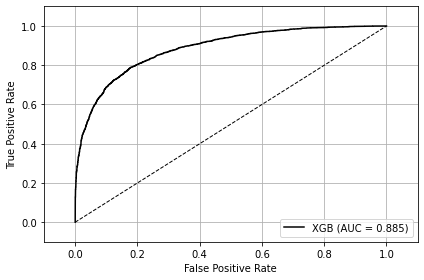

In [17]:
# Plot Roc Curve

colors = ['blue']
linestyles = ['--']
#plt.figure(figsize=(5,5))
fpr, tpr, thresholds = roc_curve(y_test, xgb_pred[:,1],pos_label=1)
roc_auc = auc(x=fpr, y=tpr)
plt.plot(fpr, tpr,
             color='k',
             linestyle='-',
             label='%s (AUC = %0.3f)' % ('XGB', roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='black',
         linewidth=1)

plt.title('')
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.tight_layout()
plt.show()  

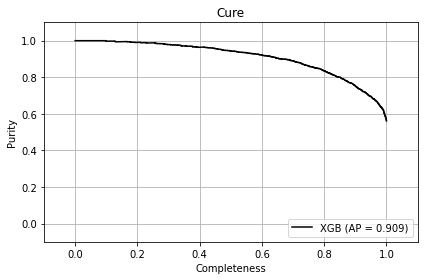

In [18]:
# Plot Purity x Completeness 


precision_cure, recall_cure, thresholds_cure = precision_recall_curve(y_test, xgb_pred[:,1],pos_label=1)
average_precision_cure = average_precision_score(y_test, xgb_pred[:,1])
plt.plot(recall_cure, precision_cure, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision_cure))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Cure')
plt.tight_layout()
plt.show()  

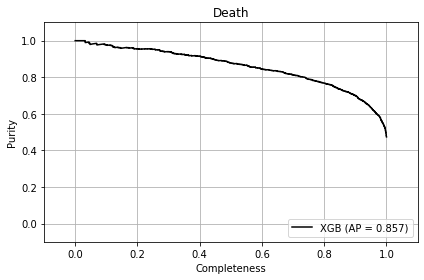

In [19]:
# Plot Purity x Completeness 


precision_death, recall_death, thresholds_death = precision_recall_curve(y_test, xgb_pred[:,0],pos_label=0)
average_precision_death = average_precision_score(1-y_test, xgb_pred[:,0])
plt.plot(recall_death, precision_death, color='k',linestyle='-',label='%s (AP = %0.3f)' % ('XGB', average_precision_death))

plt.legend(loc='lower right')


plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('Completeness')
plt.ylabel('Purity')
plt.title('Death')
plt.tight_layout()
plt.show()  

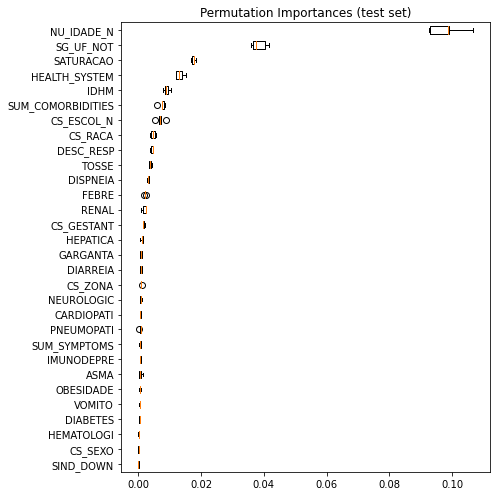

In [20]:
from sklearn.inspection import permutation_importance


result = permutation_importance(loaded_model_xgb, x_test, y_test, n_repeats=5,
                                random_state=42, n_jobs=2, scoring='average_precision')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(7,7))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=x_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
#ax.set_xscale('log')
fig.tight_layout()
#plt.savefig('importance_permutation_train.pdf')
plt.show()  

In [21]:
# Data number


# general
print('Public number of data %d' % (y_test[x_test['HEALTH_SYSTEM']==1].shape[0]) )
print('Private number of data %d' % (y_test[x_test['HEALTH_SYSTEM']==0].shape[0]) )
print('General data %d' % (y_test.shape[0]))

Public number of data 5152
Private number of data 1512
General data 6664


In [22]:
# ROC Public and Private


# public
pred_public = loaded_model_xgb.predict_proba(x_test[x_test['HEALTH_SYSTEM']==1])
fpr_public, tpr_public, thresholds_public = roc_curve(y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,1], pos_label=1)
pred_auc_public = auc(x=fpr_public, y=tpr_public)


# private
pred_private = loaded_model_xgb.predict_proba(x_test[x_test['HEALTH_SYSTEM']==0])
fpr_private, tpr_private, thresholds_private = roc_curve(y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,1], pos_label=1)
pred_auc_private = auc(x=fpr_private, y=tpr_private)
    
    
print('Public AUC = %0.3f, number of data %d' % (pred_auc_public, y_test[x_test['HEALTH_SYSTEM']==1].shape[0]) )
print('Private AUC = %0.3f, number of data %d' % (pred_auc_private, y_test[x_test['HEALTH_SYSTEM']==0].shape[0]) )

Public AUC = 0.869, number of data 5152
Private AUC = 0.903, number of data 1512


In [23]:
# Plot Purity x Completeness 


# Public Cure
precision_cure, recall_cure, thresholds_cure = precision_recall_curve(y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,1],pos_label=0)
average_precision_cure = average_precision_score(y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,1])

print('Public cure AUC = %0.3f, number of data %d' % (average_precision_cure, y_test[x_test['HEALTH_SYSTEM']==1].shape[0]))


# Private Cure
precision_cure_private, recall_cure_private, thresholds_cure_private = precision_recall_curve(y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,1],pos_label=0)
average_precision_private = average_precision_score(y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,1])

print('Private cure  AUC = %0.3f, number of data %d' % (average_precision_private, y_test[x_test['HEALTH_SYSTEM']==0].shape[0]))


Public cure AUC = 0.872, number of data 5152
Private cure  AUC = 0.966, number of data 1512


In [24]:
# Plot Purity x Completeness 


# Public death
precision_death, recall_death, thresholds_death = precision_recall_curve(y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,0],pos_label=0)
average_precision_death = average_precision_score(1-y_test[x_test['HEALTH_SYSTEM']==1], pred_public[:,0])

print('Public death AUC = %0.3f, number of data %d' % (average_precision_death, y_test[x_test['HEALTH_SYSTEM']==1].shape[0]))


# Private death
precision_death_private, recall_death_private, thresholds_death_private = precision_recall_curve(y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,0],pos_label=0)
average_precision_private = average_precision_score(1-y_test[x_test['HEALTH_SYSTEM']==0], pred_private[:,0])

print('Private death  AUC = %0.3f, number of data %d' % (average_precision_private, y_test[x_test['HEALTH_SYSTEM']==0].shape[0]))


Public death AUC = 0.867, number of data 5152
Private death  AUC = 0.760, number of data 1512
